In [1]:
import os
import sys
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Custom module imports
from utils import *
from models import GeneratorNumIntEnergyDirection2
from dataloader import FastDataloader

/home/youness/Softwares/Anaconda/anaconda3/envs/pytorch_Cuda11/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Configuration and Constants
CONFIG = {
    "POSITRON_EMITTER": "F18",
    "LATENT_DIM": 100,
    "NUM_STEPS": 18,
    "NUM_FEATURES": 4,  # Energy, X, Y, Z
    "BATCH_SIZE": 20000,
    "MATERIAL": "Water",
    "DATA_DIR": "",
    "MIN_SELECTION": 0,
    "MAX_SELECTION": 20,
    "LEARNING_RATE": 1e-4,
    "NUM_EPOCHS": 10000,
}

CONFIG["NUM_STEPS"] = 18 # The maximum number of steps in the positron path, 30 for Ga62
CONFIG["DATA_DIR"] = f"/home/youness/data/Positron_Range_Project/WData/{CONFIG['MATERIAL']}{CONFIG['POSITRON_EMITTER']}/"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Data Preparation
def prepare_data(data_dir, min_selection, max_selection, batch_size):
    input_data_list = [np.load(os.path.join(data_dir, f)) for f in sorted(os.listdir(data_dir))
                       if "positrons_" in f and min_selection < int(f.split("_")[1].split(".")[0]) < max_selection]
    numpy_array = np.concatenate(input_data_list)[:20000]
    dataset = FastDataloader(numpy_array)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [5]:
# Model Loading
def load_model(path_to_weights, device, seq_len):
    model = GeneratorNumIntEnergyDirection2(seq_len=seq_len).to(device)
    model.load_state_dict(torch.load(path_to_weights))
    return model

In [6]:


# Prediction Generation
def generate_predictions(generator, dataloader, device):
    generator.eval()
    total_time = time.time()
    output_gpaths, output_rpaths, output_count = [], [], []

    for i, batch in enumerate(dataloader):
        start_time = time.time()
        real_path, num_inter, energy, masks, start_vector = [tensor.to(device) for tensor in batch]
        # make real_path, start_vector, energy, masks as float:
        real_path = real_path.float()
        start_vector = start_vector.float()
        energy = energy.float()
        masks = masks.float()
        with torch.no_grad():
            hidden = torch.randn(len(num_inter), 100).to(device)
            fake_path_test = generator(hidden, num_inter, energy, masks, start_vector)
        
        print(f'Batch: {i}, Time: {time.time() - start_time}s')
        output_gpaths.append(fake_path_test)
        output_rpaths.append(real_path)
        output_count.append(num_inter)

    print(f'Total time: {time.time() - total_time}s')  
    return torch.cat(output_gpaths, dim=0), torch.cat(output_rpaths, dim=0), torch.cat(output_count, dim=0)

In [9]:
def main():
    # Prepare data
    dataloader = prepare_data(CONFIG["DATA_DIR"], CONFIG["MIN_SELECTION"], CONFIG["MAX_SELECTION"], CONFIG["BATCH_SIZE"])
    
    # Load model
    model_path = f'/home/youness/data/Positron_Range_Project/Python/GAN_Posi/Particles_tracks_GAN.py/Weights/G_{CONFIG["POSITRON_EMITTER"]}_{CONFIG["MATERIAL"]}.pth'
    
    generator = load_model(model_path, DEVICE, CONFIG["NUM_STEPS"])
    
    # Generate predictions
    generated_paths, real_paths, data_counts = generate_predictions(generator, dataloader, DEVICE)
    
    # Analysis and Visualization
    generated_paths = generated_paths.cpu()[:,:,0,:].transpose(1,2)
    real_paths = real_paths.cpu()[:,:,0,:].transpose(1,2)

    generated_paths_np = make_values_zero(generated_paths.cpu().detach().numpy(), data_counts)
    real_paths_np      = real_paths.cpu().detach().numpy()
    
    # Assuming get_final_points returns the final (E, X, Y, Z) for each path
    g_final_points, r_final_points = get_final_points(generated_paths_np, real_paths_np)
    
    # Do some statistics on the final points, points contains E, x, y, z:
    g_final_points = np.array(g_final_points)
    r_final_points = np.array(r_final_points)
    print("Final points statistics:")
    print("Generated:")
    print("Mean: ", np.mean(g_final_points, axis=0))
    print("Std: ", np.std(g_final_points, axis=0))
    print("Real:")
    print("Mean: ", np.mean(r_final_points, axis=0))
    print("Std: ", np.std(r_final_points, axis=0))

    # Measure RMSE between generated and real final points, only for x, y, z:
    print("RMSE: ", np.sqrt(np.mean((g_final_points[:, 1:] - r_final_points[:, 1:])**2, axis=0)))
    # Measure RMSE between generated and 0,0,0 only for x, y, z:
    print("generated RMSE: ", np.sqrt(np.mean((g_final_points[:, 1:] - np.zeros_like(g_final_points[:, 1:]))**2, axis=0)))
    print("real      RMSE: ", np.sqrt(np.mean((r_final_points[:, 1:] - np.zeros_like(r_final_points[:, 1:]))**2, axis=0)))

    # get the maximum idstance between a generated point and the 0,0,0 point:
    print("generated Max distance: ", np.max(np.linalg.norm(g_final_points[:, 1:], axis=1)))
    print("real      Max distance: ", np.max(np.linalg.norm(r_final_points[:, 1:], axis=1)))
    # get mean distance between a generated point and the 0,0,0 point:
    print("generated Mean distance: ", np.mean(np.linalg.norm(g_final_points[:, 1:], axis=1)))
    print("real      Mean distance: ", np.mean(np.linalg.norm(r_final_points[:, 1:], axis=1)))


    generated_grid, real_grid = generate_3D_images(generated_paths_np, real_paths_np, image_shape=(35, 35, 35), voxel_size_mm=0.3)

    draw_animated(generated_grid, real_grid)

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(generated_grid[generated_grid.shape[0]//2, :, :], cmap ='hot')
    ax[0].set_title("Generated")
    ax[1].imshow(real_grid[generated_grid.shape[0]//2, :, :], cmap ='hot')
    ax[1].set_title("real")
    ax[2].imshow(generated_grid[generated_grid.shape[0]//2, :, :] - real_grid[generated_grid.shape[0]//2, :, :], cmap='bwr', vmin=-200, vmax=200)
    ax[2].set_title("Generated-real")
    plt.show()



    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    # Display the generated grid
    im0 = ax[0].imshow(generated_grid[generated_grid.shape[0]//2, :, :], cmap='hot', vmax=600)
    ax[0].set_title("Generated")

    # Display the real grid
    im1 = ax[1].imshow(real_grid[generated_grid.shape[0]//2, :, :], cmap='hot', vmax=600)
    ax[1].set_title("Real")

    # Calculate and display the percentage difference
    percentage_difference = ((generated_grid[generated_grid.shape[0]//2, :, :] - real_grid[generated_grid.shape[0]//2, :, :]) / np.max(real_grid[generated_grid.shape[0]//2, :, :])) * 100
    im2 = ax[2].imshow(percentage_difference, cmap='bwr', vmin=-50, vmax=50)
    # show the colorbar:
    cbar = plt.colorbar(im2, ax=ax[2], orientation='vertical', fraction=.1)
    ax[2].set_title("Generated vs. Real (Percentage)")

    plt.show()

    plt.show()
    print(generated_paths_np.shape, real_paths_np.shape)
   

    min_x, max_x = {'Water': (-2, 2), 'RibBone': (-1.5, 1.5), 'Lung': (-6, 6)}.get(CONFIG["MATERIAL"], (-2, 2))


    #plot_xyz_histograms(generated_1Material_paths, real_1Material_paths, min_x=min_x, max_x=max_x, num_bins = 101, save=True, path="/home/youness/Documents/"+Material+"_1000dpi.pdf",)

    plot_x_distribution(generated_paths_np, real_paths_np, min_x=min_x, max_x=max_x, num_bins = 101)
    plot_y_distribution(generated_paths_np, real_paths_np, min_x=min_x, max_x=max_x, num_bins = 101)
    plot_z_distribution(generated_paths_np, real_paths_np, min_x=min_x, max_x=max_x, num_bins = 101)

    plot_generated_paths(generated_paths_np[:100], real_paths_np[:100])
    plot_final_points(generated_paths_np[:100], real_paths_np[:100])

Batch: 0, Time: 5.47145414352417s
Total time: 5.737746477127075s
Final points statistics:
Generated:
Mean:  [ 0.         -0.00685452  0.01993108 -0.00537156]
Std:  [0.         0.37261997 0.36120939 0.37656723]
Real:
Mean:  [0.         0.00192146 0.00400064 0.00424281]
Std:  [0.         0.36619748 0.36775435 0.36987535]
RMSE:  [0.27337623 0.26860331 0.27435469]
generated RMSE:  [0.37268301 0.36175886 0.37660554]
real      RMSE:  [0.36620253 0.36777611 0.36989968]
generated Max distance:  1.882897669303551
real      Max distance:  1.9929133546765945
generated Mean distance:  0.5215783860088113
real      Mean distance:  0.5264473796529242


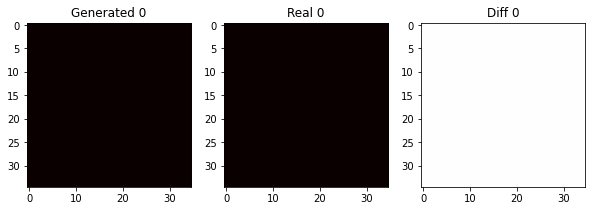

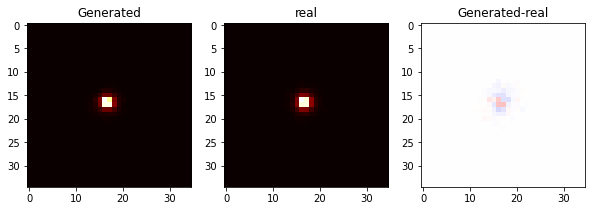

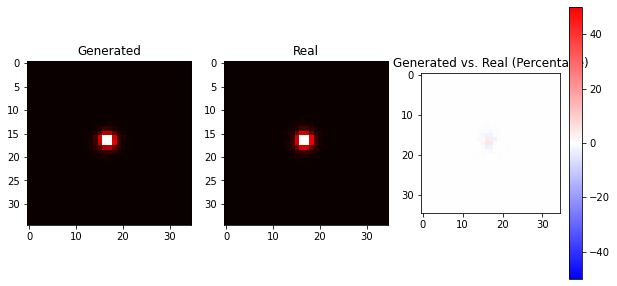

(20000, 18, 4) (20000, 18, 4)


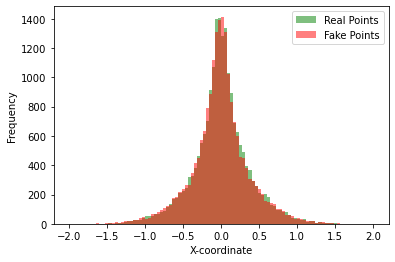

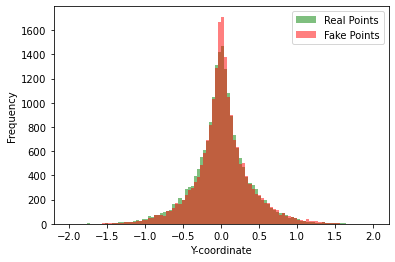

/home/youness/Softwares/Anaconda/anaconda3/envs/pytorch_Cuda11/lib/python3.9/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


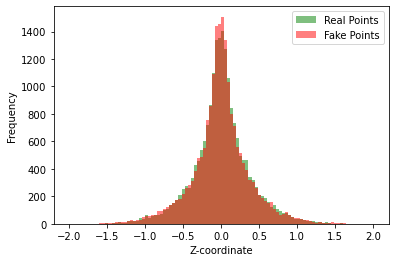

No handles with labels found to put in legend.


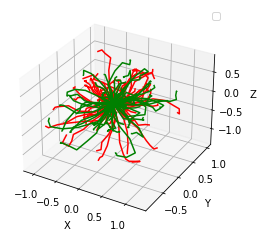

No handles with labels found to put in legend.


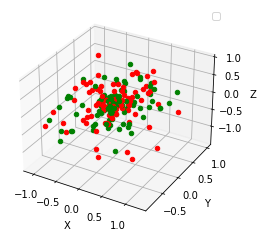

In [10]:
main()